In [25]:
import re
import requests
import networkx as nx
from bs4 import BeautifulSoup
from collections import defaultdict
import math

In [14]:
filter_station_pattern = re.compile(r'\w+')
def getStations(trs):
    res = []
    title = trs[0].find_all('th')
    if title[0].text.strip() == "车站名称":
        index = 0
    elif title[1].text.strip() == "车站名称" and len(trs[1].find_all('th')) != 0:
        index = 0
    else:
        index = 1
    for tr in trs[1:]:
        tds = tr.find_all("td")
        if len(tds) > 1:
            res += [filter_station_pattern.findall(tds[index].text)[0]]
    return res

defaultdict(<class 'list'>, {'车站信息\u3000\u3000': ['宋家庄站', '肖村站', '小红门站', '旧宫站', '亦庄桥站', '亦庄文化园站', '万源街站', '荣京东街站', '荣昌东街站', '同济南路站', '经海路站', '次渠南站', '次渠站', '亦庄火车站'], '北京地铁八通线车站列表': ['四惠站', '高碑店站', '传媒大学站', '双桥站', '管庄站', '八里桥站', '通州北苑站', '九棵树站', '梨园站'], '北京地铁4号线、大兴线车站列表': ['天宫院站', '生物医药基地站', '义和庄站', '黄村火车站', '黄村西大街站', '清源路站', '枣园站', '高米店南站', '高米店北站', '西红门站', '新宫站', '公益西桥站', '角门西站', '马家堡站', '北京南站', '陶然亭站', '菜市口站', '宣武门站', '西单站', '灵境胡同站', '西四站', '平安里站', '新街口站', '西直门站', '动物园站', '国家图书馆站', '魏公村站', '人民大学站', '海淀黄庄站', '中关村站', '北京大学东门站', '圆明园站', '西苑站', '北宫门站', '安河桥北站'], '北京地铁房山线车站列表\u3000\u3000': ['阎村东站', '苏庄站', '良乡南关站', '良乡大学城西站', '良乡大学城站', '良乡大学城北站', '广阳城站', '篱笆房站', '长阳站', '稻田站', '大葆台站', '郭公庄站', '首经贸站'], '北京地铁昌平线车站列表': ['西土城站', '六道口站', '西二旗站', '生命科学园站', '朱辛庄站', '巩华城站', '沙河高教园站', '南邵站', '北邵洼站', '昌平站', '十三陵景区站'], '北京地铁机场线车站信息': ['东直门站', '三元桥站', '3号航站楼站', '2号航站楼站'], '北京地铁1号线车站列表': ['苹果园站', '古城站', '八角游乐园站', '八宝山站', '玉泉路站', '五棵松站', '万寿路站', '公主坟站', '军事博物馆站', '木樨地站', '南礼士路站', '复兴门站', '西单站', '天安门西站', 

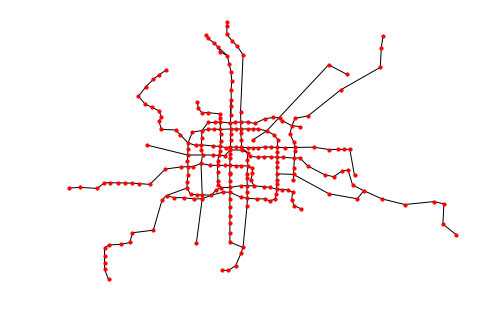

In [15]:
common_link = "https://baike.baidu.com"
url = 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81/408485'

# Getting url response
headers = {"User-Agent": "User-Agent:Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0;"}
response = requests.get(url, headers=headers, allow_redirects=False)
# response.apparent_encoding  for getting 编码方式
# response.encoding = "utf-8"
html = response.content.decode(encoding='utf-8')

# Getting all train routes
soup = BeautifulSoup(html)
caption = soup.find('caption')
contents = caption.next_sibling.find_all('a')
pattern = re.compile(r'href=\"(.*)\" ')
temp = [''.join(pattern.findall(str(content))) for content in contents]
router_links = sorted(list(set(temp)))

#Getting all stations with extra invalid stations
train_station_T = defaultdict(list)
pattern1 = re.compile(r'\w+站')
for router_link in router_links:
    respond_link = requests.get(common_link + router_link, headers=headers, allow_redirects=False)
#     respond_link.encoding = "utf-8"
    soup1 = BeautifulSoup(respond_link.content.decode(encoding='utf-8'))
    for a in soup1.find_all("caption"):
        if re.findall("车站列表", a.text):
            find_station_list = a
            break
        elif re.findall("车站信息", a.text):
            find_station_list = a
    next_siblings = find_station_list.next_sibling.find_all("tr")
    stations = getStations(next_siblings)
    train_station_T[find_station_list.text] = stations

#################################北京地铁站坐标#################################

coordinate_location_url = "http://ifamily.wang/2018/06/21/2018-06-20/"
res_coordinate_location = requests.get(coordinate_location_url)

html_coordinate_location = res_coordinate_location.content.decode(encoding='utf-8')
# res_coordinate_location.encoding = "utf-8"
soup = BeautifulSoup(html_coordinate_location)
station_coordinate_location = defaultdict(list)
station_name_pattern = re.compile(r'\w+')
for tr in soup.find_all('tr')[1:]:
    tds = tr.find_all("td")
    name = station_name_pattern.findall(tds[1].text)[0]
    if name[-1] == "站":
        name = name[:-1]
    station_coordinate_location[name + "站"] = (float(tds[-2].text), float(tds[-1].text))

station_coordinate_location['2号航站楼站'] = station_coordinate_location.get("T2航站楼站")
station_coordinate_location.pop("T2航站楼站")
station_coordinate_location['3号航站楼站'] = station_coordinate_location.get("T3航站楼站")
station_coordinate_location.pop("T3航站楼站")

#################################Matching all train stations with station coordinate #################################

station_coordinate_locationTT = {}
station_connection = defaultdict(list)
train_station_TT = defaultdict(list)

for key, value in station_coordinate_location.items():
    if value != []:
        station_coordinate_locationTT[key] = value

for key, values in train_station_T.items():
    for value in values:
        if station_coordinate_locationTT.get(value) != None:
            train_station_TT[key].append(value)

print(train_station_TT)
print(station_coordinate_locationTT)
            
for key, values in train_station_TT.items():
    for index, value in enumerate(values[:-1]):
        station_connection[value].append(values[index + 1])
        station_connection[values[index + 1]].append(value)

################################# Ploting train staions and their edges #################################
station_location2 = nx.Graph(station_connection)
nx.draw(station_location2, station_coordinate_locationTT, with_labels=False, node_size=10)

In [23]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d


def bfs(graph, start):
    visited= [start]
    seen = set()
    while visited:
        frontier = visited.pop()
        if frontier in seen:
            continue
        for successor in graph[frontier]:
            if successor in seen:
                continue
            visited = [successor] + visited   # 广义优先搜素(用队列来进行)
            # visited = visited + successor   # 深度优先搜素(用栈来进行)
        seen.add(frontier)
    return seen


def search(start, destination, graph, sort_candidate):
    pathes = [[start]]
    visited = set()
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]
        if frontier in visited:
            continue
        for city in graph[frontier]:
            if city in path: continue
            new_path = path +[city]
            pathes.append(new_path)
            if city == destination:
                print(new_path)
                return new_path
        visited.add(frontier)
        print(pathes)
        pathes = sort_candidate(pathes)  # sort function for controlling serarch strategy


def get_geo_distance(origin, destination):
    return geo_distance(station_coordinate_locationTT[origin], station_coordinate_locationTT[destination])


def get_path_distance(path):
    distance = 0
    for i, station in enumerate(path[:-1]):
        distance += get_geo_distance(station, path[i+1])
    return distance


def transfer_station_first(pathes):
    return sorted(pathes, key=len)


def transfer_as_much_as_possible(pathes):
    return sorted(pathes, key=len, reverse=True)


def shortest_path_first(pathes):
    return sorted(pathes, key=get_path_distance)

In [11]:
#################################Matching all train stations with station coordinate #################################

In [26]:
search('天通苑站', '2号航站楼站', station_connection, sort_candidate=shortest_path_first)

[['天通苑站', '天通苑南站'], ['天通苑站', '天通苑北站']]
[['天通苑站', '天通苑南站'], ['天通苑站', '天通苑北站', '平西府站']]
[['天通苑站', '天通苑北站', '平西府站'], ['天通苑站', '天通苑南站', '立水桥站']]
[['天通苑站', '天通苑北站', '平西府站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站']]
[['天通苑站', '天通苑北站', '平西府站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站']]
[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站']]
[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '关庄站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站']]
[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '关庄站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站']]
[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '关庄站', '望京西站']]
[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '关庄站', '望京西站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', 

[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '亮马桥站', '农业展览馆站', '团结湖站', '呼家楼站', '金台夕照站', '国贸站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '中国美术馆站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站', '北沙滩站', '六道口站', '西土城站', '知春路站', '知春里站', '海淀黄庄站', '中关村站', '北京大学东门站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站', '北沙滩站', '六道口站', '西土城站', '知春路站', '知春里站', '海淀黄庄站', '中关村站', '北京大学东门站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '安贞门站', '北土城站', '安华桥站', '安德里北街站', '鼓楼大街站', '什刹海站', '南锣鼓巷站', '中国美术馆站', '王府井站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '崇文门站', '磁器口站', '桥湾站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '建国门站', '永

[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站', '北沙滩站', '六道口站', '西土城站', '知春路站', '知春里站', '海淀黄庄站', '苏州街站', '巴沟站', '火器营站', '长春桥站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '天安门东站', '天安门西站', '西单站', '灵境胡同站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '天安门东站', '天安门西站', '西单站', '灵境胡同站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '崇文门站', '磁器口站', '天坛东门站', '蒲黄榆站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '虎坊桥站', '菜市口站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '亮马桥站', '农业展览馆站', '团结湖站', '呼家楼站', '金台夕照站', '国贸站', '双井站', '广渠门外站'], ['天通苑站', '

[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '安贞门站', '北土城站', '安华桥站', '安德里北街站', '鼓楼大街站', '什刹海站', '南锣鼓巷站', '北海北站', '平安里站', '车公庄站', '车公庄西站', '白石桥南站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '虎坊桥站', '菜市口站', '宣武门站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '虎坊桥站', '菜市口站', '宣武门站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '虎坊桥站', '菜市口站', '陶然亭站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '虎坊桥站', '菜市口站', '陶然亭站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站', '北沙滩站', '六道口站', '西土城站', '知春路站', '知春里站', '海淀黄庄站'

[['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '亮马桥站', '农业展览馆站', '团结湖站', '呼家楼站', '金台夕照站', '国贸站', '双井站', '劲松站', '潘家园站', '十里河站', '方庄站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '亮马桥站', '农业展览馆站', '团结湖站', '呼家楼站', '金台夕照站', '国贸站', '双井站', '劲松站', '潘家园站', '十里河站', '分钟寺站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '安立路站', '奥林匹克公园站', '北沙滩站', '六道口站', '西土城站', '知春路站', '知春里站', '海淀黄庄站', '苏州街站', '巴沟站', '火器营站', '长春桥站', '车道沟站', '慈寿寺站', '花园桥站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '天桥站', '永定门外站', '北京南站', '马家堡站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '和平西桥站', '和平里北街站', '雍和宫站', '北新桥站', '张自忠路站', '东四站', '灯市口站', '东单站', '王府井站', '前门站', '珠市口站', '天桥站', '永定门外站', '北京南站', '马家堡站'], ['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '亮马桥站', 

['天通苑站', '天通苑南站', '立水桥站', '北苑路北站', '大屯路东站', '惠新西街北口站', '惠新西街南口站', '芍药居站', '太阳宫站', '三元桥站', '3号航站楼站', '2号航站楼站']


['天通苑站',
 '天通苑南站',
 '立水桥站',
 '北苑路北站',
 '大屯路东站',
 '惠新西街北口站',
 '惠新西街南口站',
 '芍药居站',
 '太阳宫站',
 '三元桥站',
 '3号航站楼站',
 '2号航站楼站']


##################梯度下降算法###################################
